## DonorsChoose Funding Analysis 
<br>
DonorsChoose is an innovative platform that connects donors with teachers from across the United States to fund school projects. These projects range from simple supplies for a science experiment to funds for field trips, providing resources that schools otherwise might not afford. In this project, you will analyze data from the DonorsChoose platform to identify patterns in funding, project success, and factors that influence donor contributions.



Download the specified CSV files from Canvas and load them into Python for analysis.

In [87]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [91]:
# Load data
project = pd.read_csv("/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/0. MPS (4th year sem 2)/MPS Spring '24/NBA 6215 Python for Business/data_for_final_project/project.csv")

donation = pd.read_csv("/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/0. MPS (4th year sem 2)/MPS Spring '24/NBA 6215 Python for Business/data_for_final_project/donation.csv")

school = pd.read_csv("/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/0. MPS (4th year sem 2)/MPS Spring '24/NBA 6215 Python for Business/data_for_final_project/school.csv")

account = pd.read_csv("/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/0. MPS (4th year sem 2)/MPS Spring '24/NBA 6215 Python for Business/data_for_final_project/account.csv",dtype={5: str}) #requires data type specification for column 5

In [95]:
# Rename columns for consistency with other files
donation = donation.rename(columns={'donoracctid':'accountid'})
project = project.rename(columns={'teacheracctid':'accountid'})

In [99]:
# Merge files to a combined dataframe
tmp0 = project.merge(donation, on=['accountid', 'projectid'], how='outer')
tmp1 = tmp0.merge(school, on='schoolid', how='outer')
combined_df = tmp1.merge(account,on='accountid', how='outer')

,projectid,accountid,schoolid,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,vendor_shipping_charges,sales_tax,payment_processing_charges,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donationid,donation_timestamp,donation_to_project,donation_optional_support,donation_total,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,is_teacher_referred,givingpageid,giving_page_type,for_honoree,thank_you_packet_mailed,ncesid,latitude,longitude,city_x,state_x,zip,metro,district,county,charter,magnet,year_round,nlns,kipp,charter_ready_promise,city_y,state_y,zip3,is_teacher,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow
0,1.00,1,1.00,Other,Applied Learning,NaN,NaN,Supplies,highest poverty,Grades 6-8,NaN,NaN,NaN,NaN,229.00,279.27,0.00,251.90,1.00,0.00,0.00,completed,2002-09-13 00:00:00,2002-09-23 00:00:00,2003-01-27 00:00:00,2003-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360009702803.00,40.69,-73.91,New York City,NY,11207.00,urban,New York City Dept Of Ed,Kings (Brooklyn),0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Mr.,0.00,0.00
1,86.00,1,1.00,History & Geography,History & Civics,NaN,NaN,Technology,highest poverty,Grades 6-8,NaN,NaN,NaN,NaN,263.00,320.73,0.00,289.30,1.00,0.00,0.00,completed,2002-09-19 00:00:00,2003-01-27 00:00:00,2003-03-26 00:00:00,2003-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360009702803.00,40.69,-73.91,New York City,NY,11207.00,urban,New York City Dept Of Ed,Kings (Brooklyn),0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Mr.,0.00,0.00
2,105.00,1,1.00,Other,Applied Learning,NaN,NaN,Other,highest poverty,Grades 6-8,NaN,NaN,NaN,NaN,9.00,10.98,0.00,230.00,2.00,0.00,0.00,completed,2002-09-19 00:00:00,2002-09-19 00:00:00,2003-01-27 00:00:00,2003-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360009702803.00,40.69,-73.91,New York City,NY,11207.00,urban,New York City Dept Of Ed,Kings (Brooklyn),0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Mr.,0.00,0.00
3,892.00,1,1.00,Literacy,Literacy & Language,NaN,NaN,Supplies,highest poverty,Grades 6-8,NaN,NaN,NaN,NaN,427.00,520.73,0.00,492.00,1.00,0.00,0.00,completed,2003-06-13 00:00:00,2003-09-08 00:00:00,2003-11-19 00:00:00,2003-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360009702803.00,40.69,-73.91,New York City,NY,11207.00,urban,New York City Dept Of Ed,Kings (Brooklyn),0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Mr.,0.00,0.00
4,260.00,159,1.00,Literacy,Literacy & Language,NaN,NaN,Supplies,highest poverty,Grades 6-8,NaN,NaN,NaN,NaN,816.00,995.12,0.00,861.45,2.00,0.00,0.00,completed,2002-11-07 00:00:00,2003-02-05 00:00:00,2003-08-01 00:00:00,2003-07-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360009702803.00,40.69,-73.91,New York City,NY,11207.00,urban,New York City Dept Of Ed,Kings (Brooklyn),0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Mr.,0.00,0.00


In [104]:
# Remove NA values from the donation_to_project column (imperative column)
combined_df = combined_df.dropna(subset=['donation_to_project'])

In [105]:
# Sort by accountid
pd.set_option('display.max_columns', 500)
combined_df.sort_values('accountid')
combined_df

,projectid,accountid,schoolid,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,vendor_shipping_charges,sales_tax,payment_processing_charges,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donationid,donation_timestamp,donation_to_project,donation_optional_support,donation_total,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,is_teacher_referred,givingpageid,giving_page_type,for_honoree,thank_you_packet_mailed,ncesid,latitude,longitude,city_x,state_x,zip,metro,district,county,charter,magnet,year_round,nlns,kipp,charter_ready_promise,city_y,state_y,zip3,is_teacher,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow
68,147974.00,14659,2.00,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 9-12,32.14,0.00,4.82,9.00,367.35,447.99,200.00,447.99,3.00,1.00,0.00,completed,2009-08-12 00:00:00,2009-09-08 00:00:00,2009-12-04 00:00:00,2010-01-13 00:00:00,4905337.00,2009-08-21 09:06:42,20.50,4.50,25.00,1.00,creditcard,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,360007700585.00,40.77,-73.96,New York City,NY,10065.00,NaN,New York City Dept Of Ed,New York (Manhattan),0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Ms.,0.00,0.00
74,212598.00,14659,2.00,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Other,highest poverty,Grades 9-12,22.56,0.00,3.38,35.00,286.54,329.36,200.00,325.62,6.00,0.00,1.00,completed,2010-07-23 00:00:00,2010-09-08 00:00:00,2011-01-18 00:00:00,2010-12-23 00:00:00,3409988.00,2010-09-02 22:15:55,43.50,6.50,50.00,1.00,creditcard,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,360007700585.00,40.77,-73.96,New York City,NY,10065.00,NaN,New York City Dept Of Ed,New York (Manhattan),0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Ms.,0.00,0.00
90,802020.00,14659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556299.00,2015-02-13 14:58:54,42.50,7.50,50.00,1.00,no_cash_received,0.00,0.00,1.00,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,Ms.,0.00,0.00
91,778850.00,14659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,935423.00,2014-12-02 17:51:10,8.50,1.50,10.00,1.00,paypal,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,Ms.,0.00,0.00
105,110794.00,34241,3.00,Literacy,Literacy & Language,Special Needs,Special Needs,Technology,moderate poverty,Grades PreK-2,23.32,0.00,5.83,17.00,279.00,340.24,25.00,348.75,2.00,0.00,0.00,completed,2008-11-22 00:00:00,2009-04-21 00:00:00,2009-04-24 00:00:00,2009-04-23 00:00:00,2725696.00,2008-12-12 20:17:57,20.00,5.00,25.00,1.00,no_cash_received,0.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,0.00,360007702569.00,40.77,-73.95,New York City,NY,10075.00,NaN,New York City Dept Of Ed,New York (Manhattan),0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,1.00,Ms.,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179429,70405.00,2855583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6211919.00,2008-03-31 14:12:13,85.00,15.00,100.00,1.00,no_cash_received,0.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Hollywood,CA,900.00,0.00,NaN,NaN,NaN
7179430,108

________________________________________________________________________________________________

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
donation[["donation_to_project", "donation_optional_support", "donation_total"]].describe()

,donation_to_project,donation_optional_support,donation_total
count,6211956.00,6211956.00,6211956.00
mean,69.73,10.94,80.66
std,247.89,37.82,280.89
min,-12.75,-2.25,-15.00
25%,10.00,1.50,10.00
50%,21.25,3.75,25.00
75%,53.76,7.50,61.20
max,147204.00,21996.00,169200.00


<Axes: xlabel='payment_method', ylabel='count'>

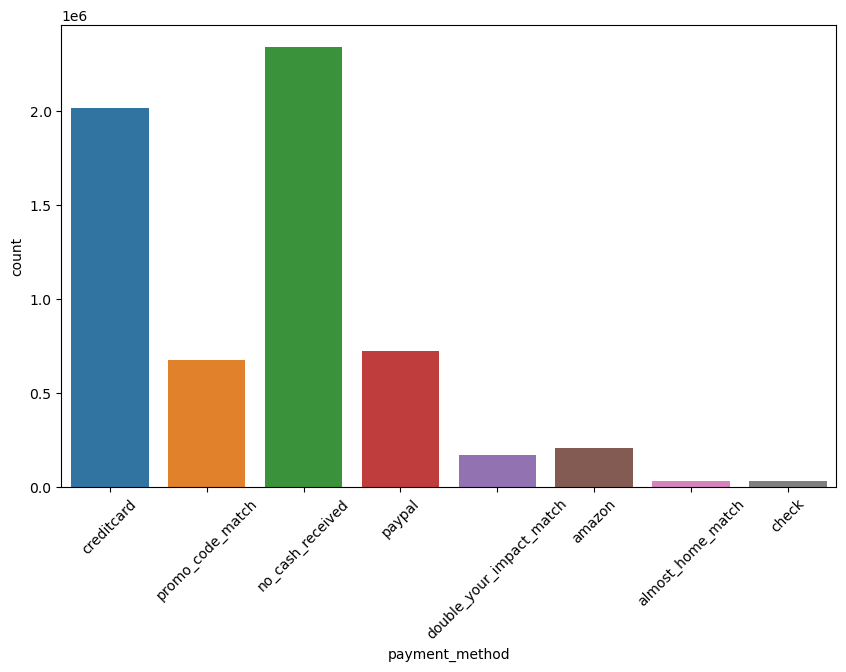

In [9]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.countplot(data=donation, x='payment_method')

<Axes: xlabel='payment_method', ylabel='donation_to_project'>

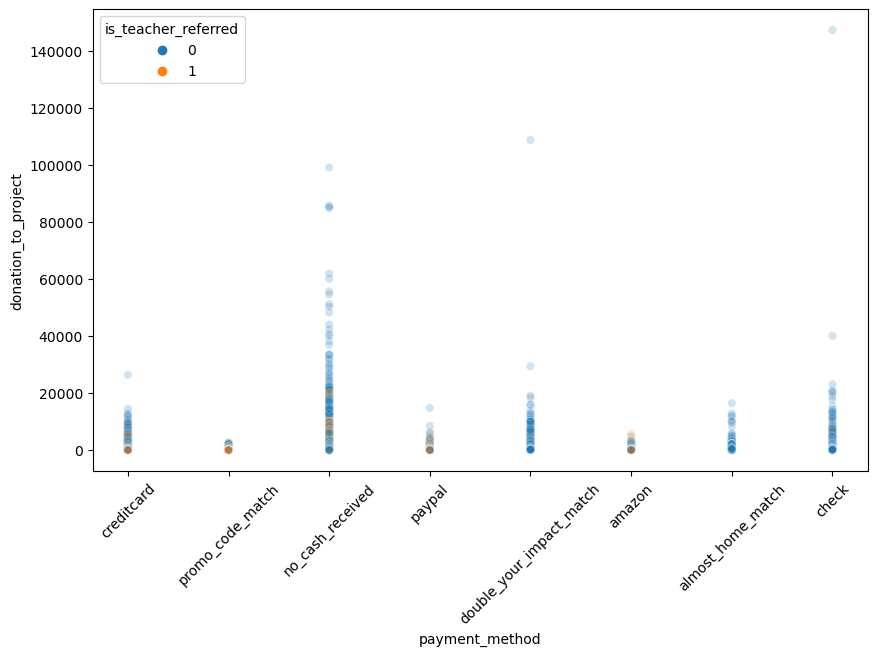

In [23]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.scatterplot(data=donation, x='payment_method', y='donation_to_project', hue='is_teacher_referred', alpha=0.2)

In [11]:
donation_df = donation.drop(columns=['projectid', 'donoracctid', 'donation_timestamp', 'givingpageid'])

In [12]:
donation_df = pd.get_dummies(donation_df, columns=["giving_page_type", "payment_method"])

In [13]:
donation_df.head()

,donationid,donation_to_project,donation_optional_support,donation_total,donation_included_optional_support,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,is_teacher_referred,...,giving_page_type_campaign,giving_page_type_teacher,payment_method_almost_home_match,payment_method_amazon,payment_method_check,payment_method_creditcard,payment_method_double_your_impact_match,payment_method_no_cash_received,payment_method_paypal,payment_method_promo_code_match
0,1,8.50,1.50,10.00,1,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,2,63.75,11.25,75.00,1,0,0,0,1,0,...,False,False,False,False,False,True,False,False,False,False
2,3,21.25,3.75,25.00,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3,4,20.50,4.50,25.00,1,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,5,1817.36,320.71,2138.07,1,1,0,0,0,0,...,True,False,False,False,False,False,False,True,False,False


In [14]:
data_train, data_test = train_test_split(donation_df)

In [15]:
X_train, X_test = data_train.drop(columns=["donation_total", "donation_to_project", "donation_optional_support"]), data_test.drop(columns=["donation_total", "donation_to_project", "donation_optional_support"])

y_train, y_test = data_train["donation_total"], data_test["donation_total"]

In [16]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
len(data_test['donationid'])

1552989

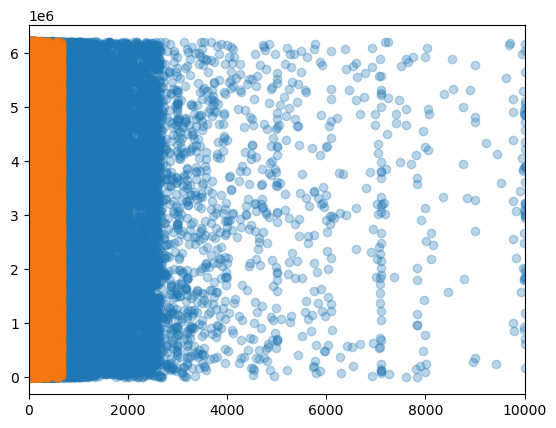

In [18]:
plt.scatter(data_test['donation_total'], data_test['donationid'], alpha=0.3)
plt.scatter(y_pred, data_test['donationid'], alpha=0.1)
plt.xlim(0, 10000)  # Set the limit for x-axis
plt.show()